# ABOD

In [1]:
import numpy as np
import itertools
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

class FastABOD:
    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors

    def fit_predict(self, X, contamination=0.1):
        # 各点のk最近傍を求める
        k_nearest = NearestNeighbors(n_neighbors=self.n_neighbors).fit(X)
        distances, indices = k_nearest.kneighbors(X)
        # k最近傍との角度を求めるための組み合わせ計算
        numbers = [i + 1 for i in range(distances.shape[1] - 1)]
        combs = list(itertools.combinations(numbers, 2))
        # ABOFを求める
        abofs = []
        for i in range(len(X)):
            x = X[indices[i]]
            abof = self._compute_abof(x, combs)
            abofs.append(abof)
        # ABOFスコア下位N%を異常と見なす
        ordered_abofs = np.argsort(abofs)
        anomaly_indices = ordered_abofs[:int(len(abofs)*contamination + 0.5)]
        # scikit-learnに倣って正常を1、異常を-1として返す
        prediction = np.ones((len(abofs)), dtype=np.int)
        prediction[anomaly_indices] = -1
        return prediction

    def _compute_abof(self, x, combs):
        numerator1 = 0
        numerator2 = 0
        denominator1 = 0
        for comb in combs:
            AB = x[comb[0]] - x[0]
            AC = x[comb[1]] - x[0]
            AB_norm = np.linalg.norm(AB)
            AC_norm = np.linalg.norm(AC)
            a = 1 / (AB_norm * AC_norm)
            b = np.dot(AB, AC) / ((AB_norm ** 2) * (AC_norm ** 2))
            numerator1 += a * (b ** 2)
            denominator1 += a
            numerator2 += a * b
        denominator2 = denominator1
        return numerator1 / denominator1 - (numerator2 / denominator2) ** 2

In [2]:
#np.random.seed(42)

# Generate train data
X = 0.3 * np.random.randn(100, 2)
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X + 2, X - 2, X_outliers]


In [3]:

# fit the model
clf = FastABOD(n_neighbors=10)
# 全体の9%が異常データ
contamination = 0.09
y_pred = clf.fit_predict(X, contamination)
# 正常を1、異常を-1と出力します
ANOMALY_DATA = -1
predicted_outlier_index = np.where(y_pred == ANOMALY_DATA)
predicted_outlier = X[predicted_outlier_index]


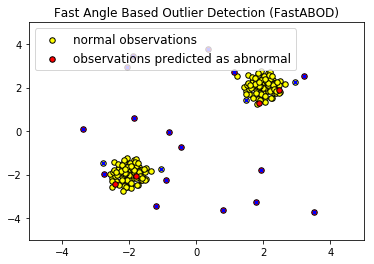

In [5]:

# plot the level sets of the decision function
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
#Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
#Z = Z.reshape(xx.shape)

plt.title("Fast Angle Based Outlier Detection (FastABOD)")
#plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

a = plt.scatter(X[:200, 0], X[:200, 1], c='yellow',
                edgecolor='k', s=30, marker='o')
b = plt.scatter(X[200:, 0], X[200:, 1], c='red',
                edgecolor='k', s=30, marker='o')
c = plt.scatter(predicted_outlier[:, 0], predicted_outlier[:, 1], c='blue',
                edgecolor='k', s=10, marker='x')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a, b, c],
           ["normal observations",
#            "abnormal observations",
            "observations predicted as abnormal"],
           loc="upper left", prop={'size': 12})
plt.show()
